<a href="https://colab.research.google.com/github/crackspace770/model-tflite/blob/main/fruit-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import os

# モデルのsaveフォルダ
base_save_dir = '/content/gdrive/My Drive/Mount Point/'
if not os.path.exists(base_save_dir):
    os.makedirs(base_save_dir)

In [6]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mankos","key":"95c3981b96278e0a9a9160e9b8630406"}'}

In [7]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q --upgrade pip
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 62 Jan 29 10:42 kaggle.json
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.9 MB/s eta 0:00:00


In [8]:
!kaggle datasets download -d moltean/fruits

 98% 1.26G/1.28G [00:05<00:00, 287MB/s]
100% 1.28G/1.28G [00:05<00:00, 250MB/s]


In [9]:
!unzip -q fruits.zip
!rm fruits.zip

In [10]:
ls

fruits-360_dataset/        gdrive/      sample_data/
fruits-360-original-size/  kaggle.json


In [11]:
# ファイル名とそれぞれのターゲットラベルをnumpy配列にロードします
import os
import glob
from tqdm import tqdm
import numpy as np
import cv2

train_path = "fruits-360_dataset/fruits-360/Training/*"
test_path = "fruits-360_dataset/fruits-360/Test/*"

def img2np(folder_path):
    imgs = []
    indices = []
    labels = []
    for dir_path in tqdm(glob.glob(folder_path)):
        img_label = dir_path.split("/")[-1]
        for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
            img_tmp = cv2.imread(img_path)
            img_tmp = cv2.resize(img_tmp, (100, 100)) # Default img size ==>(100, 100)
            img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB)
            imgs.append(img_tmp)            
            labels.append(img_label)
            
    imgs = np.array(imgs)
    labels = np.array(labels)
    label_to_id = {v : k for k, v in enumerate(np.unique(labels))}
    indices = np.array([label_to_id[i] for i in labels])
        
    return imgs, indices, labels

x_train, y_train, target_labels = img2np(train_path)
print('train Loading complete!')
x_test, y_test, _ = img2np(test_path)
print('test Loading complete!')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

100%|██████████| 131/131 [00:20<00:00,  6.43it/s]


train Loading complete!


100%|██████████| 131/131 [00:05<00:00, 23.91it/s]


test Loading complete!
Training set size :  67692
Testing set size :  22688


In [12]:
# クラスの数を確認
num_of_classes = len(np.unique(y_train))
num_of_classes

131

In [13]:
# クラスをone-hot表現に変換
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, num_of_classes)
y_test = np_utils.to_categorical(y_test, num_of_classes)

In [14]:
# テストデータのバリデーションを用意
x_test, x_valid = x_test[7000:], x_test[:7000]
y_test, y_vaild = y_test[7000:], y_test[:7000]
print('Vaildation X : ', x_valid.shape)
print('Vaildation y :', y_vaild.shape)
print('Test X : ', x_test.shape)
print('Test y : ', y_test.shape)

Vaildation X :  (7000, 100, 100, 3)
Vaildation y : (7000, 131)
Test X :  (15688, 100, 100, 3)
Test y :  (15688, 131)


In [15]:
# すべてのピクセル値[0-255]の値を[0.0-1.0]にリスケール
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255

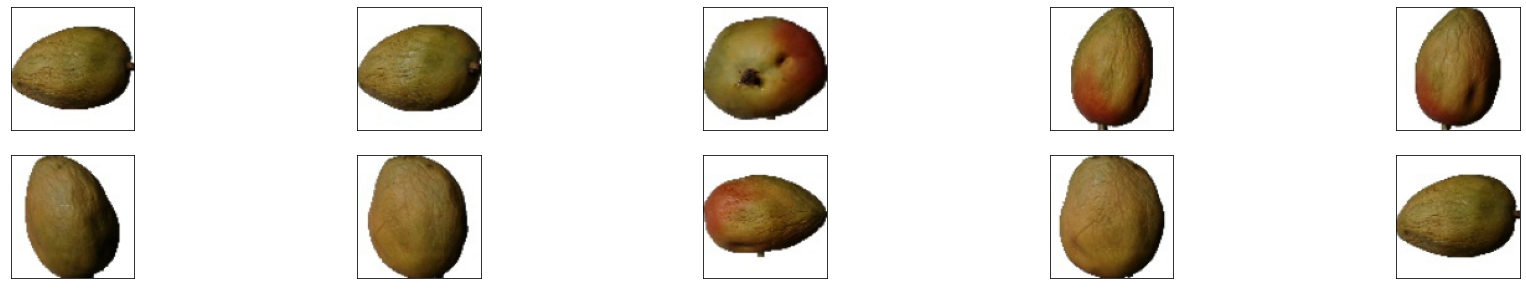

In [16]:
# 最初のトレーニングに使う10の画像をみてみましょう
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

In [17]:
# CNNモデルの構築

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape=(100, 100, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(150, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_of_classes, activation = 'softmax'))

# model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, epsilon=1e-8, decay=1e-4),
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
